<a href="https://colab.research.google.com/github/nahbos/AUT-Neural-Networks/blob/main/HW07/FCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### - Sobhan Moradian Daghigh
#### - 6/20/2022
#### - ANN - HW07

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf, keras
import tensorflow_datasets as tfds
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPool2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, Input, Conv2DTranspose, Conv2D, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications.inception_v3 import preprocess_input
from copy import copy


import warnings
warnings.filterwarnings("ignore")
import itertools
%load_ext tensorboard
import os

In [5]:
print(tf.__version__)

2.8.2


In [2]:
# !pip install -U tensorflow_datasets

In [15]:
BATCH_SIZE = 16
IMAGE_RES = 64

In [16]:
def resizer(image, label):
    image = tf.image.resize(image, [IMAGE_RES, IMAGE_RES])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return (image, label)

In [17]:
def data_preprocess(dataset):
  return dataset.map(resizer).batch(BATCH_SIZE).prefetch(1)

In [18]:
# def load_data():
#   name = 'cats_vs_dogs'
#   train, validation, test = tfds.load(name, split = ('train[:70%]', 'train[70%:80%]', 'train[80%:]'), as_supervised=True, batch_size=BATCH_SIZE)
#   print('  |_ {} loaded'.format(name))
#   return train, validation, test

In [19]:
def load_data():
  name = 'cats_vs_dogs'
  setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
  train = tfds.load(name, split='train', as_supervised=True, shuffle_files=True)
  print('  |_ {} loaded'.format(name))
  return train

In [20]:
train = load_data()

  |_ cats_vs_dogs loaded


In [21]:
train = data_preprocess(train)

In [22]:
len(train) * BATCH_SIZE

23264

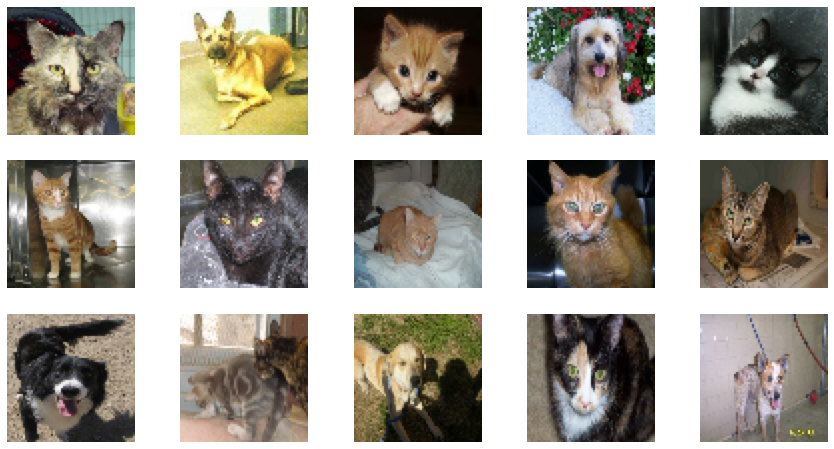

In [23]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8))
filterds = []
for images, labels in train.take(1):
  for i, (img, ax) in enumerate(zip(images, axes.reshape(-1))):
    ax.imshow(((img.numpy() * 127.5) + 127.5).astype(np.uint8))
    ax.axis('off')
plt.show()

In [24]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Defining a few hyperparameters

In [33]:
# Consistent results
np.random.seed(10)

noise_dim = 100

steps_per_epoch = 50
epochs = 1001

channels = 3

optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# FCGAN

In [27]:
def create_generator():
    generator = Sequential()

    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense((IMAGE_RES * IMAGE_RES * 3), activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [28]:
def create_descriminator():
    discriminator = Sequential()
    
    discriminator.add(Input(shape=((IMAGE_RES * IMAGE_RES * 3))))
    discriminator.add(Dense(1024))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [29]:
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(20, 17))
    
    for i, image in enumerate(generated_images):
      img_min = image.min()
      img_max = image.max()

      image = ((image - img_min)/(img_max - img_min)) * 255
      plt.subplot(10, 10, i+1)
      plt.imshow(image.reshape((IMAGE_RES, IMAGE_RES, channels)).astype(np.uint8))
      plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [34]:
discriminator = create_descriminator()
discriminator.summary()

generator = create_generator()
generator.summary()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              12583936  
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [31]:
len(list(train.take(20))[2][0])

16

In [ ]:
static_noise = np.random.normal(0, 1, size=(10, noise_dim))
show_images(static_noise)

discriminator_loss = []
generator_loss = []
temp = 20
part_of_data = list(train.take(temp))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
        
        fake_x = generator.predict(noise)

        real_x = []
        random_batch = np.random.randint(1, temp)
        selected_batch = part_of_data[random_batch][0]

        for batch_i in range(BATCH_SIZE):
          real_x.append(tf.reshape(selected_batch[batch_i], [-1]))

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    discriminator_loss.append(d_loss)
    generator_loss.append(g_loss)
    if epoch % 10 == 0:
      show_images(static_noise)

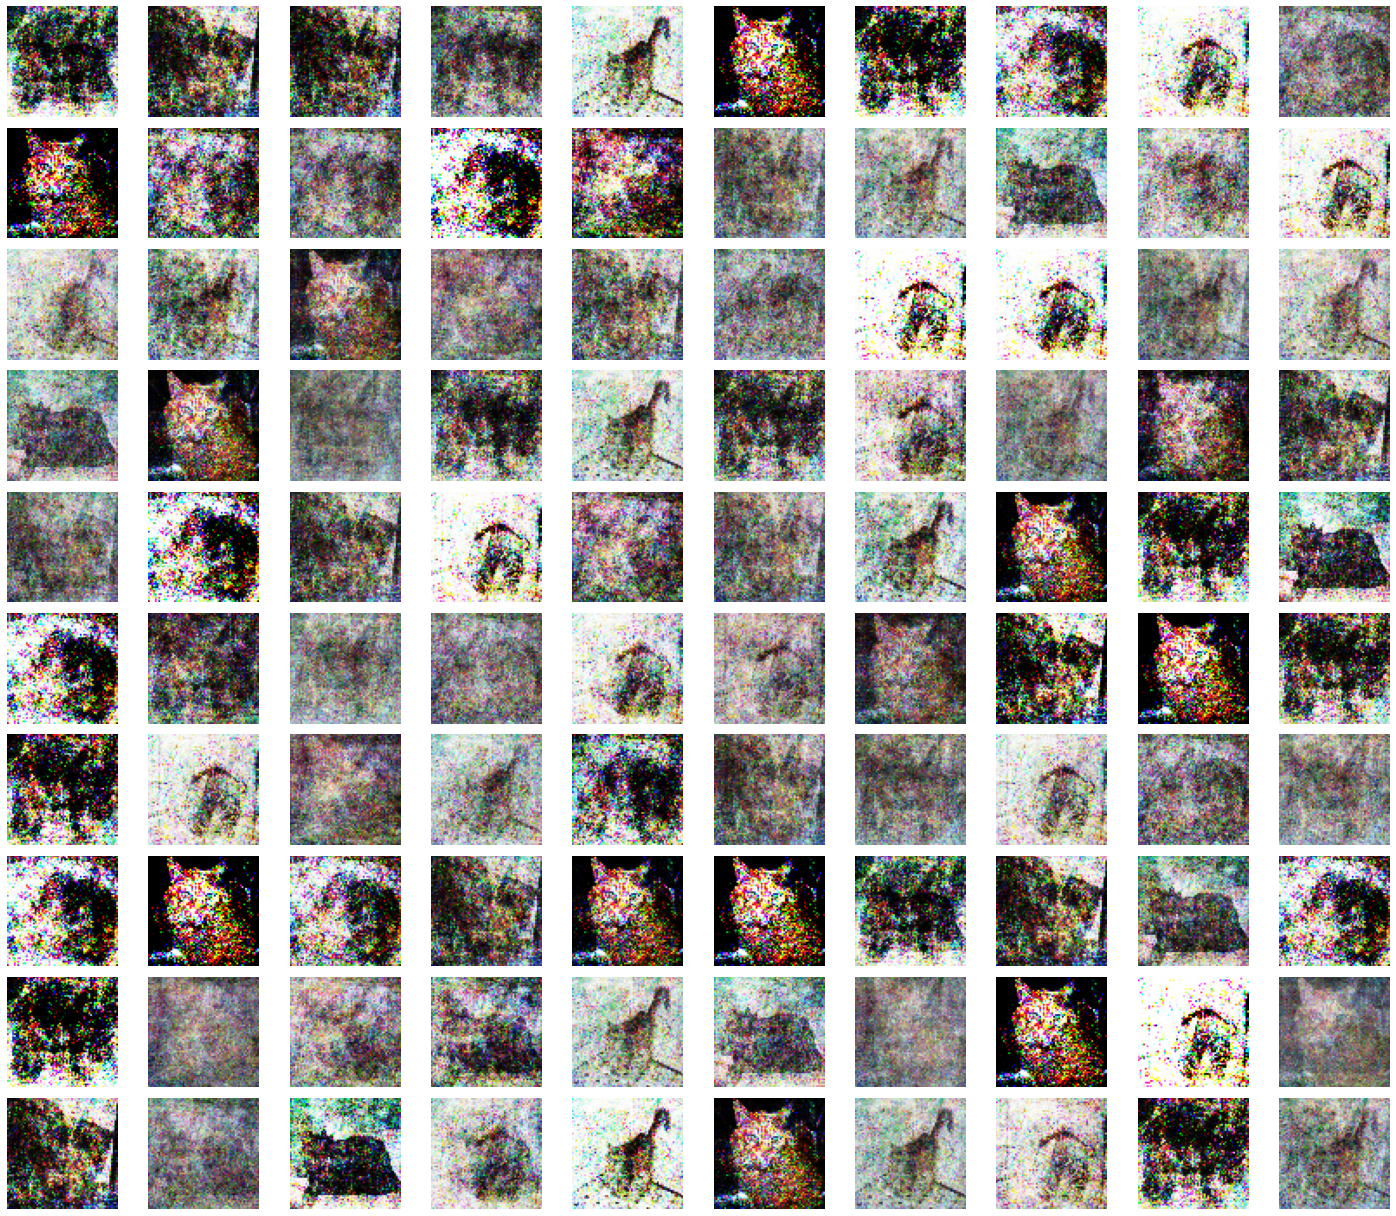

In [42]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

In [ ]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

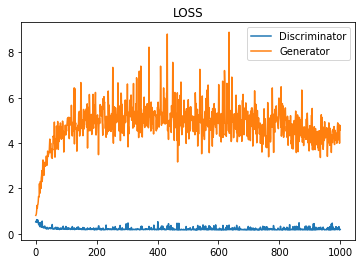

In [38]:
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(generator_loss, label='Generator')
plt.title('LOSS')
plt.legend()
plt.show()

In [72]:
def show_images2(noise):
    generated_images = generator2.predict(noise)
    plt.figure(figsize=(20, 17))
    
    for i, image in enumerate(generated_images):
      img_min = image.min()
      img_max = image.max()

      image = ((image - img_min)/(img_max - img_min)) * 255
      plt.subplot(10, 10, i+1)
      plt.imshow(image.reshape((IMAGE_RES, IMAGE_RES, channels)).astype(np.uint8))
      plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [73]:
discriminator2 = create_descriminator()
discriminator2.summary()

generator2 = create_generator()
generator2.summary()

discriminator2.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator2(gan_input)

gan_output = discriminator2(fake_image)

gan2 = Model(gan_input, gan_output)
gan2.compile(loss='binary_crossentropy', optimizer=optimizer)
gan2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 1024)              154141696 
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 1)               

In [ ]:
static_noise = np.random.normal(0, 1, size=(10, noise_dim))
show_images2(static_noise)

discriminator2_loss = []
generator2_loss = []
temp = 20
part_of_data = list(train.take(temp))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
        
        fake_x = generator2.predict(noise)

        real_x = []
        random_batch = np.random.randint(1, temp)
        selected_batch = part_of_data[random_batch][0]

        for batch_i in range(BATCH_SIZE):
          real_x.append(tf.reshape(selected_batch[batch_i], [-1]))

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 0.9

        d_loss = discriminator2.train_on_batch(x, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan2.train_on_batch(noise, y_gen)

    discriminator2_loss.append(d_loss)
    generator2_loss.append(g_loss)
    if epoch % 10 == 0:
      show_images2(static_noise)

In [ ]:
plt.plot(discriminator2_loss, label='Discriminator')
plt.plot(generator2_loss, label='Generator')
plt.title('LOSS')
plt.legend()
plt.show()

In [ ]:
plt.plot(discriminator2_loss, label='Discriminator')
plt.plot(generator2_loss, label='Generator')
plt.title('LOSS')
plt.legend()
plt.show()

# DCGAN

In [53]:
# Consistent results
np.random.seed(10)

noise_dim = 100

steps_per_epoch = 20
epochs = 51

save_path = 'dcgan-images'

IMAGE_RES, channels = 224, 3

optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [ ]:
# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [54]:
def create_generator():
  generator = Sequential()
  
  # Starting size
  d = 4
  generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
  generator.add(LeakyReLU(0.2))
  # 4x4x256
  generator.add(Reshape((d, d, 256)))
  
  # 8x8x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 16x16*128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 32x32x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 32x32x3
  generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
  
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

In [ ]:
def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(IMAGE_RES, IMAGE_RES, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(IMAGE_RES, IMAGE_RES, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [ ]:
discriminator = create_discriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(np.clip(image.reshape((img_rows, img_cols)), 0.0, 1.0), cmap='gray')
        else:
            plt.imshow(np.clip(image.reshape((img_rows, img_cols, channels)), 0.0, 1.0))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()

In [ ]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

# Training loop
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        fake_x = generator.predict(noise)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    if epoch % 2 == 0:
        show_images(static_noise, epoch)

In [ ]:
# Turn the training process into a GIF
from PIL import Image, ImageDraw

image_names = os.listdir(save_path)

frames = []
for image in sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit()))):
    frames.append(Image.open(save_path + '/' + image))

frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=80, loop=0)

discriminator.save('dcdiscriminator.h5')
generator.save('dcgenerator.h5')